In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

##Load Dataset

In [3]:
data = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/employee_retention_data.csv',
                  parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [7]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [8]:
# Null information
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

Create a table for day, employee_headcount, and company_id

In [9]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount},
                    columns=['day', 'company_id', 'employee_headcount'])

table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


##Employee Churn Analysis

In [10]:
# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

###Feature Engineering

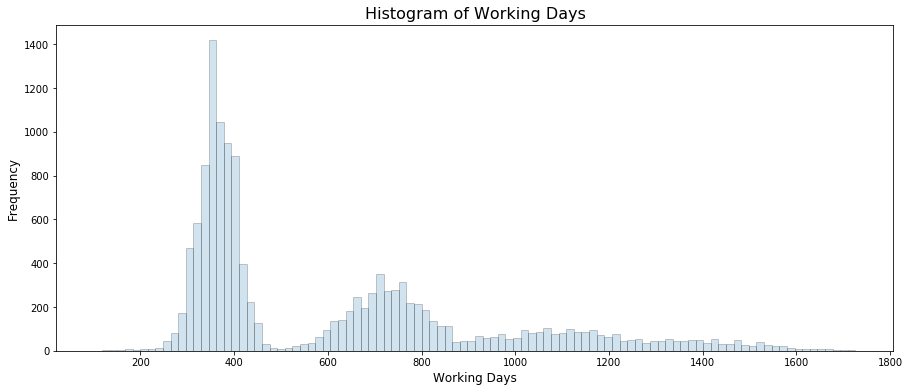

In [11]:
# How many days was a person employed? This should matter.
# People might get bored in the same place for too long
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

# Plot employee length in days
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

We can see there are peaks around each employee year anniversary.

In general, whenever you have a date, extract week of the year, and day of the week. They tend to give an idea of seasonlity and weekly trends. In this case, weekly trends probably don't matter. So let's just get week of the year.

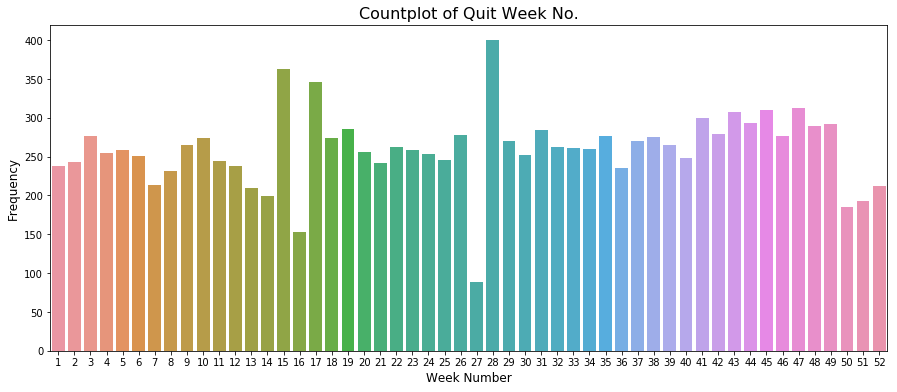

In [12]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

And it also peaks around the new year. Makes sense, companies have much more money to hire at the
beginning of the year.

In [13]:
# Choose quit data
quit_data['work_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


##Decision Tree Model

Now, let’s see if we find the characteristics of the people who quit early. Looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so. So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them).

In [14]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31) # Only keep people who had enough time to age
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
not_early_quitter = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['early_quitter'] = 1 - not_early_quitter.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,early_quitter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [53]:
# Label encoder
le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(subset['dept'])
train_y = subset['early_quitter']

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [54]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(train_x, train_y)

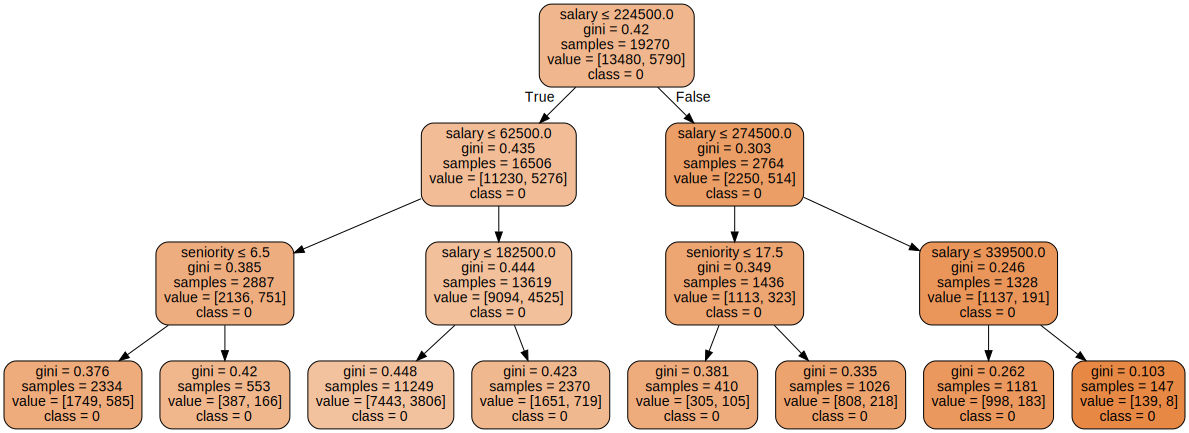

In [65]:
# Visualization
features = list(train_x.columns)
targets = ['0','1']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets,  
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

In [44]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97439
seniority  | 0.02561
company_id | 0.00000
dept       | 0.00000


Not very surprising! Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

It is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 62500 and 224500, the employee has higher probability of being an early quitter, otherwise she doesn’t. That means that people who make a lot of money and very little are not likely to quit.

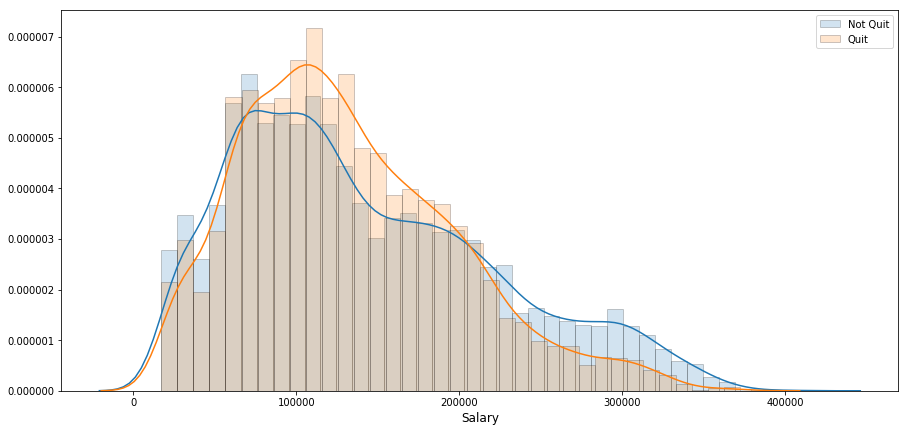

In [70]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['early_quitter']==0]['salary'],  
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['early_quitter']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.legend()
plt.show()

##Conclusion
1.Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

2.The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3.Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.